<a href="https://colab.research.google.com/github/phyuphyuthaw/portfolio-ML-AI/blob/main/age_gender_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
#
# Add your code here
#link to google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

Directory /content/drive/MyDrive/Colab Notebooks/data/train_val exists.


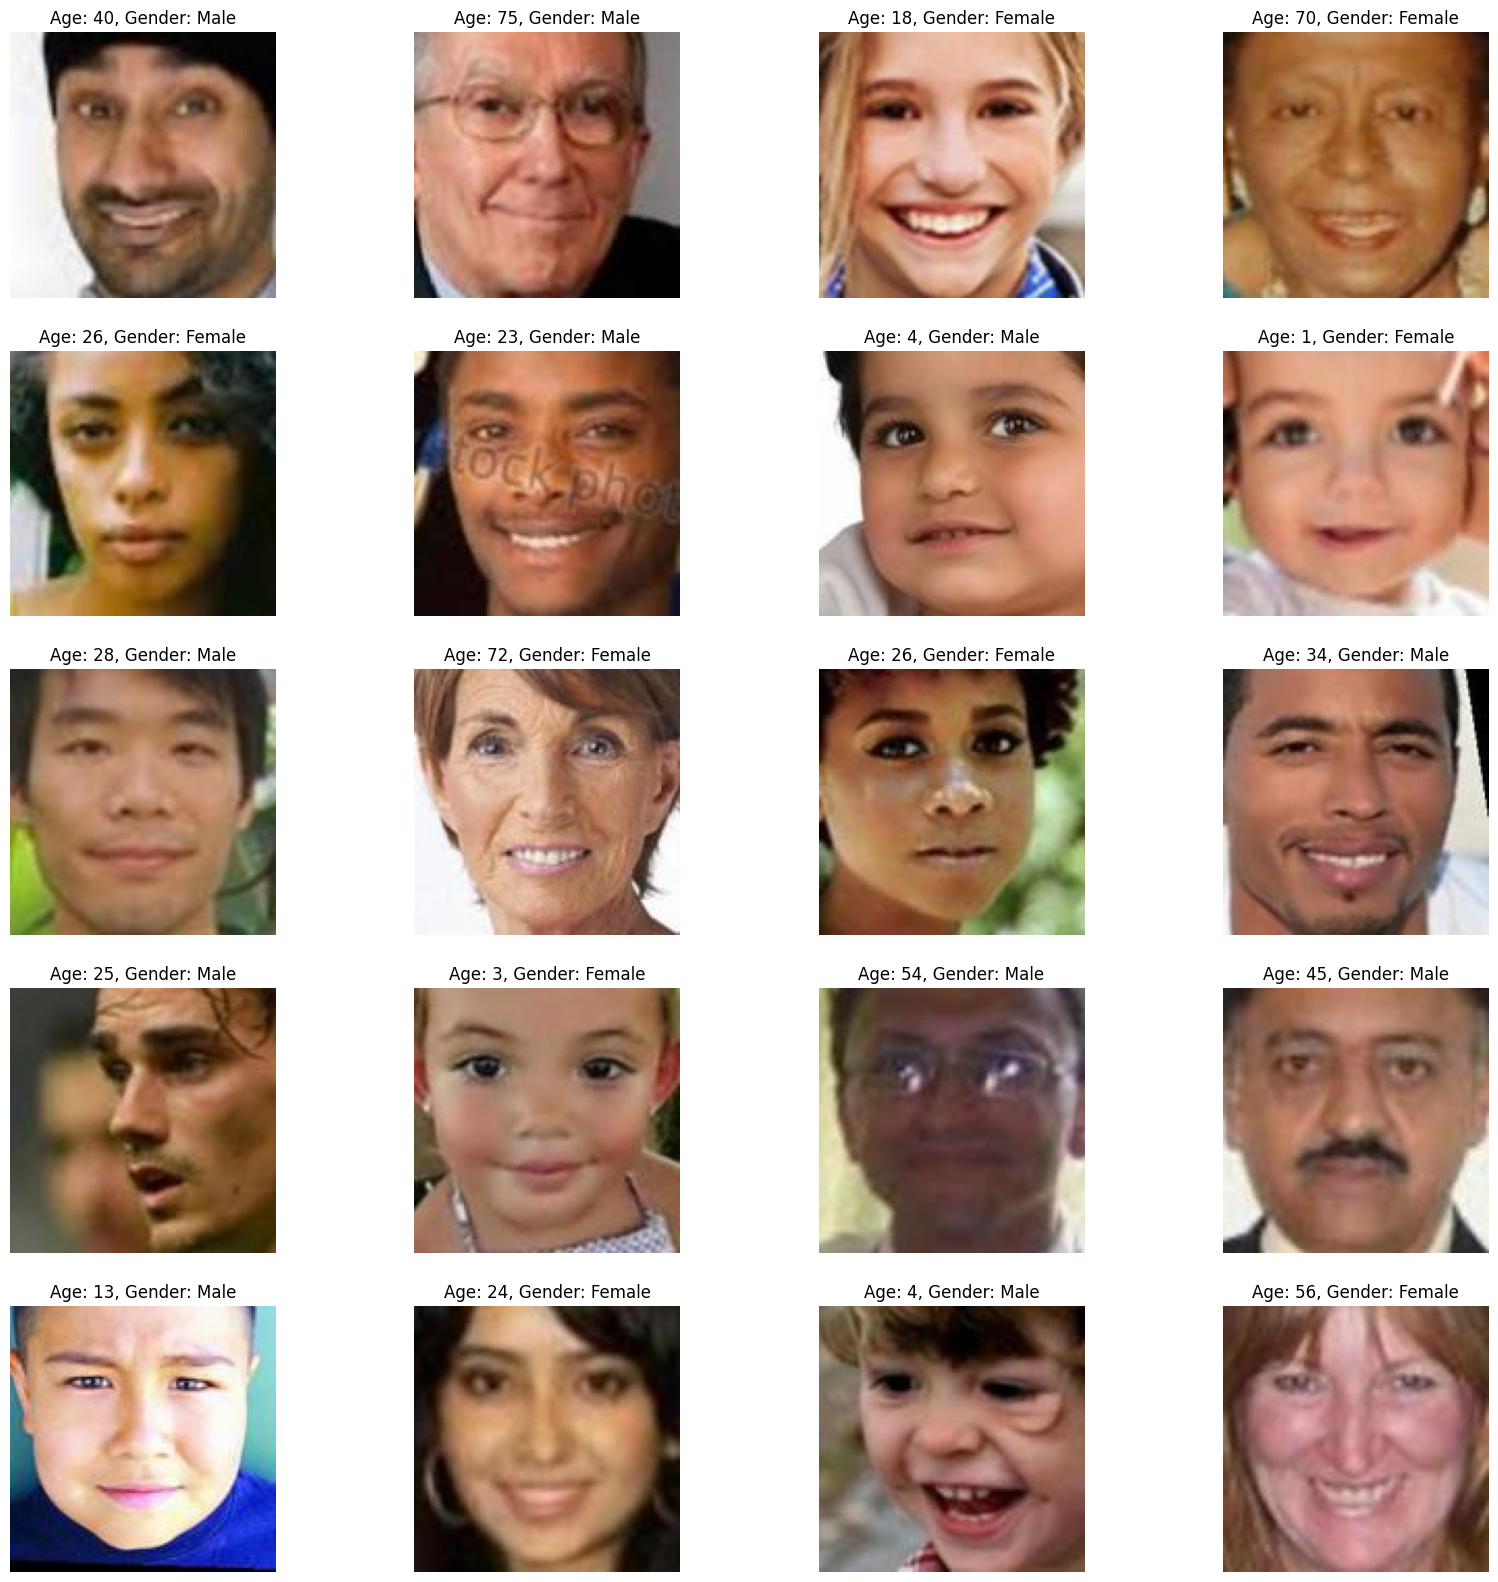

In [ ]:
#
# Add your code here
#
import os
import matplotlib.pyplot as plt
import cv2

gdrive_dir = '/content/drive/MyDrive/Colab Notebooks'
base_dir = gdrive_dir+'/data/train_val'
if not os.path.exists(base_dir):
  print(base_dir +' does not exist.')
else:
  print(f"Directory {base_dir} exists.")
  #List the files in the directory
  files = os.listdir(base_dir)
  # Display information for the first 20 images
  num_images_to_display = 20
  images_info = []
  for i, file in enumerate(files):
    if i >= num_images_to_display:
      break
    # Extract age and gender from the filename
    filename_parts = file.split('_')
    if len(filename_parts) >= 2:
      age = filename_parts[0]
      gender = 'Male' if filename_parts[1] == '0' else 'Female'
      image_path = os.path.join(base_dir, file)
      images_info.append((image_path, age, gender))
    # Plot the images with age and gender
  plt.figure(figsize=(20, 20))
  for i, (image_path, age, gender) in enumerate(images_info):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Age: {age}, Gender: {gender}')
    plt.axis('off')
  plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
#
# Add your code here
#Create train and val dataset
import shutil
import random
import pandas as pd

#Define directories
train_dir = os.path.join(gdrive_dir, 'data/train')
val_dir = os.path.join(gdrive_dir, 'data/val')

for directory in [train_dir, val_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

train_male_dir = os.path.join(train_dir, 'male')
train_female_dir = os.path.join(train_dir, 'female')
val_male_dir = os.path.join(val_dir, 'male')
val_female_dir = os.path.join(val_dir, 'female')

if not os.path.exists(train_male_dir):
    os.mkdir(train_male_dir)
if not os.path.exists(train_female_dir):
    os.mkdir(train_female_dir)
if not os.path.exists(val_male_dir):
    os.mkdir(val_male_dir)
if not os.path.exists(val_female_dir):
    os.mkdir(val_female_dir)

files = os.listdir(base_dir)
random.shuffle(files)  # Shuffle the files for randomness

# Function to extract age and gender from filename
# Filter files based on gender
male_files = [file for file in files if file.split('_')[1] == '0']
female_files = [file for file in files if file.split('_')[1] == '1']

# Define split ratio
split_ratio = 0.8
def split_and_copy_files(file_list, train_dir, val_dir, class_name):
  n_train = int(len(file_list) * split_ratio)
  n_val = len(file_list) - n_train

  train_fnames = file_list[:n_train]
  val_fnames = file_list[n_train:]

  print(f"Copying data to {train_dir} ...")
  for fname in train_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

  print(f"Copying data to {val_dir} ...")
  for fname in val_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(val_dir, fname)
    shutil.copyfile(src, dst)

  return train_fnames, val_fnames

train_male_fnames, val_male_fnames = split_and_copy_files(male_files, train_male_dir, val_male_dir, 'male')
train_female_fnames, val_female_fnames = split_and_copy_files(female_files, train_female_dir, val_female_dir, 'female')

# Function to extract age and gender from filename
def extract_labels(filenames):
  data = []
  for filename in filenames:
    parts = filename.split('_')
    age = int(parts[0])
    gender = 'Male' if parts[1] == '0' else 'Female'
    data.append({'filename': filename, 'age': age, 'gender': gender})
  return data

# Prepare CSV data
train_data = extract_labels(train_male_fnames) + extract_labels(train_female_fnames)
val_data = extract_labels(val_male_fnames) + extract_labels(val_female_fnames)

# Save labels to CSV files
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

train_df.to_csv(os.path.join(gdrive_dir, 'train_labels.csv'), index=False)
val_df.to_csv(os.path.join(gdrive_dir, 'val_labels.csv'), index=False)

print("Dataset rearrangement completed.")

Copying data to /content/drive/MyDrive/Colab Notebooks/data/train/male ...
Copying data to /content/drive/MyDrive/Colab Notebooks/data/val/male ...
Copying data to /content/drive/MyDrive/Colab Notebooks/data/train/female ...
Copying data to /content/drive/MyDrive/Colab Notebooks/data/val/female ...
Dataset rearrangement completed.


In [ ]:
# Define the directory path
train_male_dir = os.path.join(gdrive_dir, 'data/train/male')
num_male_train_files = len([name for name in os.listdir(train_male_dir) if os.path.isfile(os.path.join(train_male_dir, name))])
print(f"Number of files in {train_male_dir}: {num_male_train_files}")

# Define the directory path
val_male_dir = os.path.join(gdrive_dir, 'data/val/male')
num_male_val_files = len([name for name in os.listdir(val_male_dir) if os.path.isfile(os.path.join(val_male_dir, name))])
print(f"Number of files in {val_male_dir}: {num_male_val_files}")

# Define the directory path
train_female_dir = os.path.join(gdrive_dir, 'data/train/female')
num_female_train_files = len([name for name in os.listdir(train_female_dir) if os.path.isfile(os.path.join(train_female_dir, name))])
print(f"Number of files in {train_female_dir}: {num_female_train_files}")

# Define the directory path
val_female_dir = os.path.join(gdrive_dir, 'data/val/female')
num_female_val_files = len([name for name in os.listdir(val_female_dir) if os.path.isfile(os.path.join(val_female_dir, name))])
print(f"Number of files in {val_female_dir}: {num_female_val_files}")

n_train = num_male_train_files + num_female_train_files
n_val = num_male_val_files + num_female_val_files

Number of files in /content/drive/MyDrive/Colab Notebooks/data/train/male: 2584
Number of files in /content/drive/MyDrive/Colab Notebooks/data/val/male: 2316
Number of files in /content/drive/MyDrive/Colab Notebooks/data/train/female: 2416
Number of files in /content/drive/MyDrive/Colab Notebooks/data/val/female: 2101


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
#
# Add your code here
#Data pre-processing
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range= 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )
val_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # all images will be resized to 128x128
    batch_size=batch_size,
    class_mode='binary'  # since we use binary_crossentropy loss, we need binary labels
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.
Found 4417 images belonging to 2 classes.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

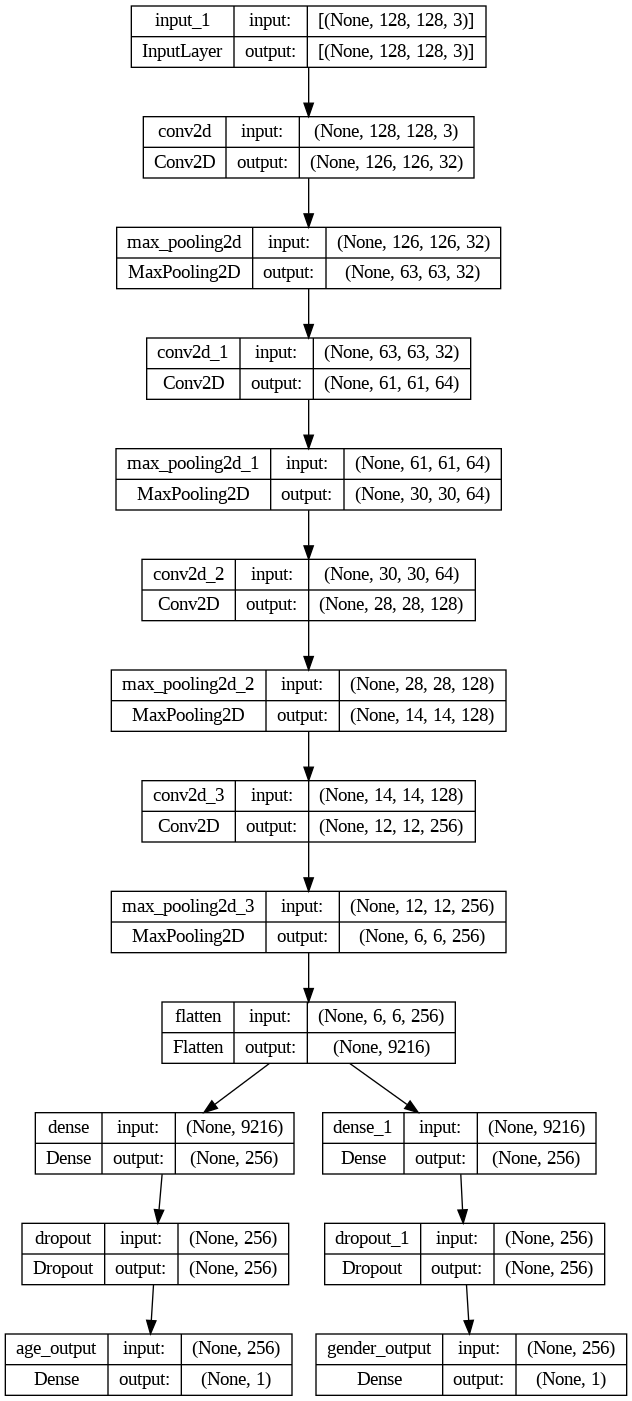

In [ ]:
#
# Add your code here
#
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

# Define the inputs
inputs = Input(shape=(128, 128, 3))
# Convolutional layers 1
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
# Convolutional layers 2
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
# Convolutional layers 3
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
# Convolutional layers 4
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

# Output layers
age_output = Dense(1, activation='linear', name='age_output') (dropout_1)
gender_output = Dense(1, activation='sigmoid', name='gender_output') (dropout_2)

# Create a new model with specified inputs and outputs
modelA = Model(inputs=inputs, outputs=[age_output, gender_output])
modelA.summary()
from keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [ ]:
#
# Add your code here
#
#STEP 3: Compile the model
batch_size = 32
valid_batch_size = 32

modelA.compile(optimizer='adam',
               loss={'age_output': 'mean_absolute_error', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

#STEP 4: Train the model
history_A = modelA.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

model_folder = '/content/drive/MyDrive/Colab Notebooks/models/'
modelA.save(model_folder+"age_gender_A.h5")

Epoch 1/30
250/250 [==============================] - 1476s 6s/step - loss: 1.1548 - age_output_loss: 0.4748 - gender_output_loss: 0.6799 - age_output_mae: 0.4748 - gender_output_accuracy: 0.5806 - val_loss: 1.0150 - val_age_output_loss: 0.3857 - val_gender_output_loss: 0.6293 - val_age_output_mae: 0.3857 - val_gender_output_accuracy: 0.6627
Epoch 2/30
250/250 [==============================] - 53s 212ms/step - loss: 1.0540 - age_output_loss: 0.4160 - gender_output_loss: 0.6380 - age_output_mae: 0.4160 - gender_output_accuracy: 0.6448 - val_loss: 0.9095 - val_age_output_loss: 0.3399 - val_gender_output_loss: 0.5696 - val_age_output_mae: 0.3399 - val_gender_output_accuracy: 0.7145
Epoch 3/30
250/250 [==============================] - 54s 214ms/step - loss: 1.0205 - age_output_loss: 0.4013 - gender_output_loss: 0.6192 - age_output_mae: 0.4013 - gender_output_accuracy: 0.6660 - val_loss: 0.8894 - val_age_output_loss: 0.3384 - val_gender_output_loss: 0.5510 - val_age_output_mae: 0.3384 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


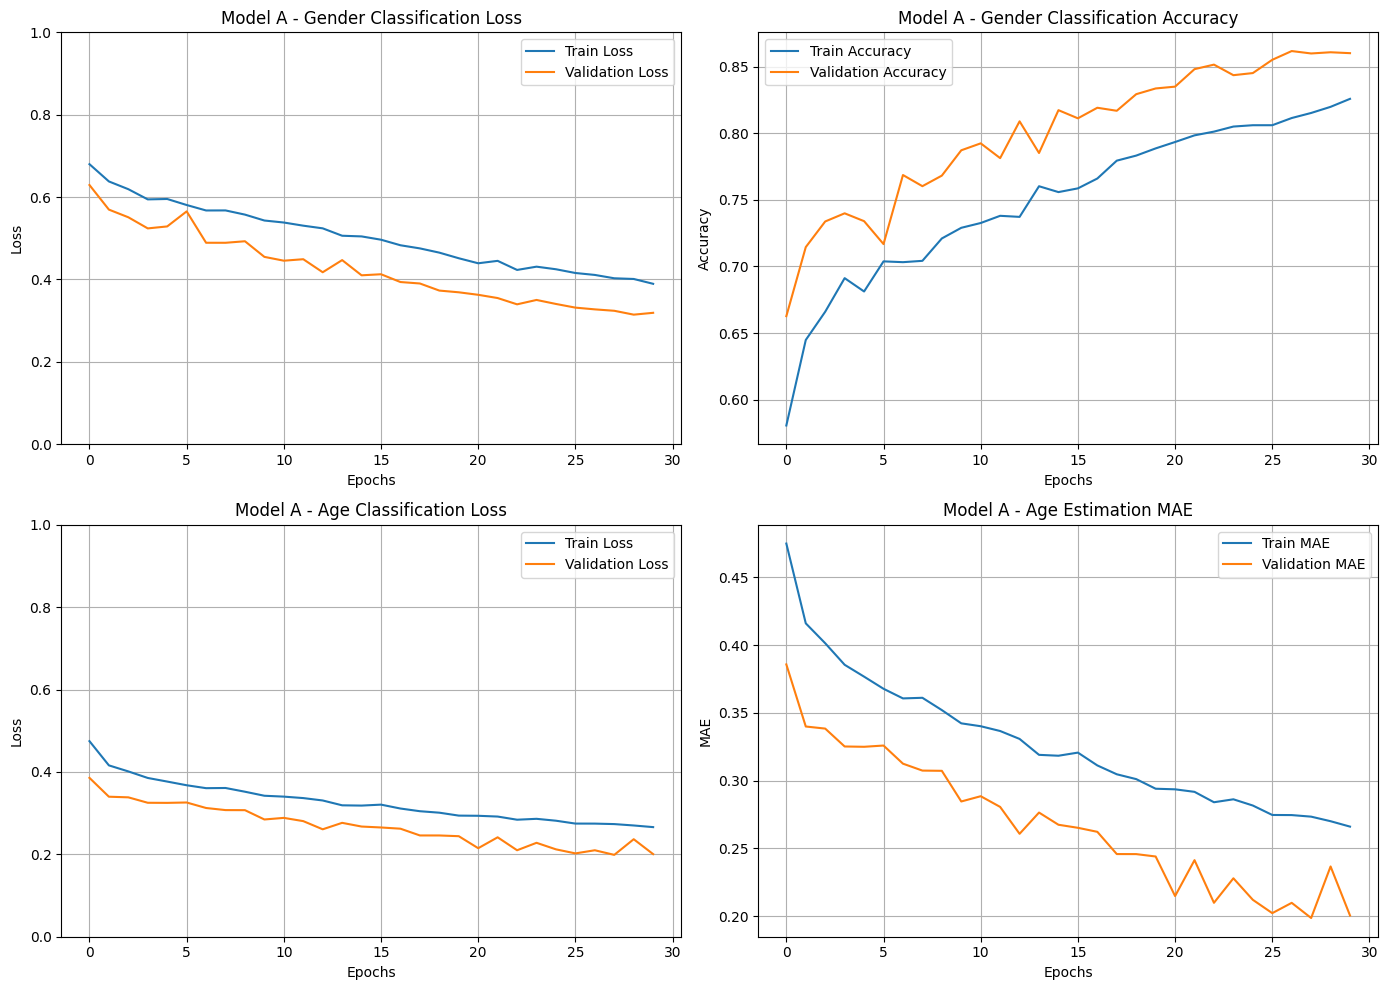

In [ ]:
#
# Add your code here
#
import matplotlib.pyplot as plt

# Create a new figure with a specified size
fig = plt.figure(figsize=(14, 10))

# Gender classification loss
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(history_A.history['gender_output_loss'], label='Train Loss')
ax1.plot(history_A.history['val_gender_output_loss'], label='Validation Loss')
ax1.set_title('Model A - Gender Classification Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax1.set_ylim([0, 1.0])

# Gender classification accuracy
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(history_A.history['gender_output_accuracy'], label='Train Accuracy')
ax2.plot(history_A.history['val_gender_output_accuracy'], label='Validation Accuracy')
ax2.set_title('Model A - Gender Classification Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Age classification loss
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(history_A.history['age_output_loss'], label='Train Loss')
ax3.plot(history_A.history['val_age_output_loss'], label='Validation Loss')
ax3.set_title('Model A - Age Classification Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)
ax3.set_ylim([0, 1.0])

# Age estimation MAE
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(history_A.history['age_output_mae'], label='Train MAE')
ax4.plot(history_A.history['val_age_output_mae'], label='Validation MAE')
ax4.set_title('Model A - Age Estimation MAE')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MAE')
ax4.legend()
ax4.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plots
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

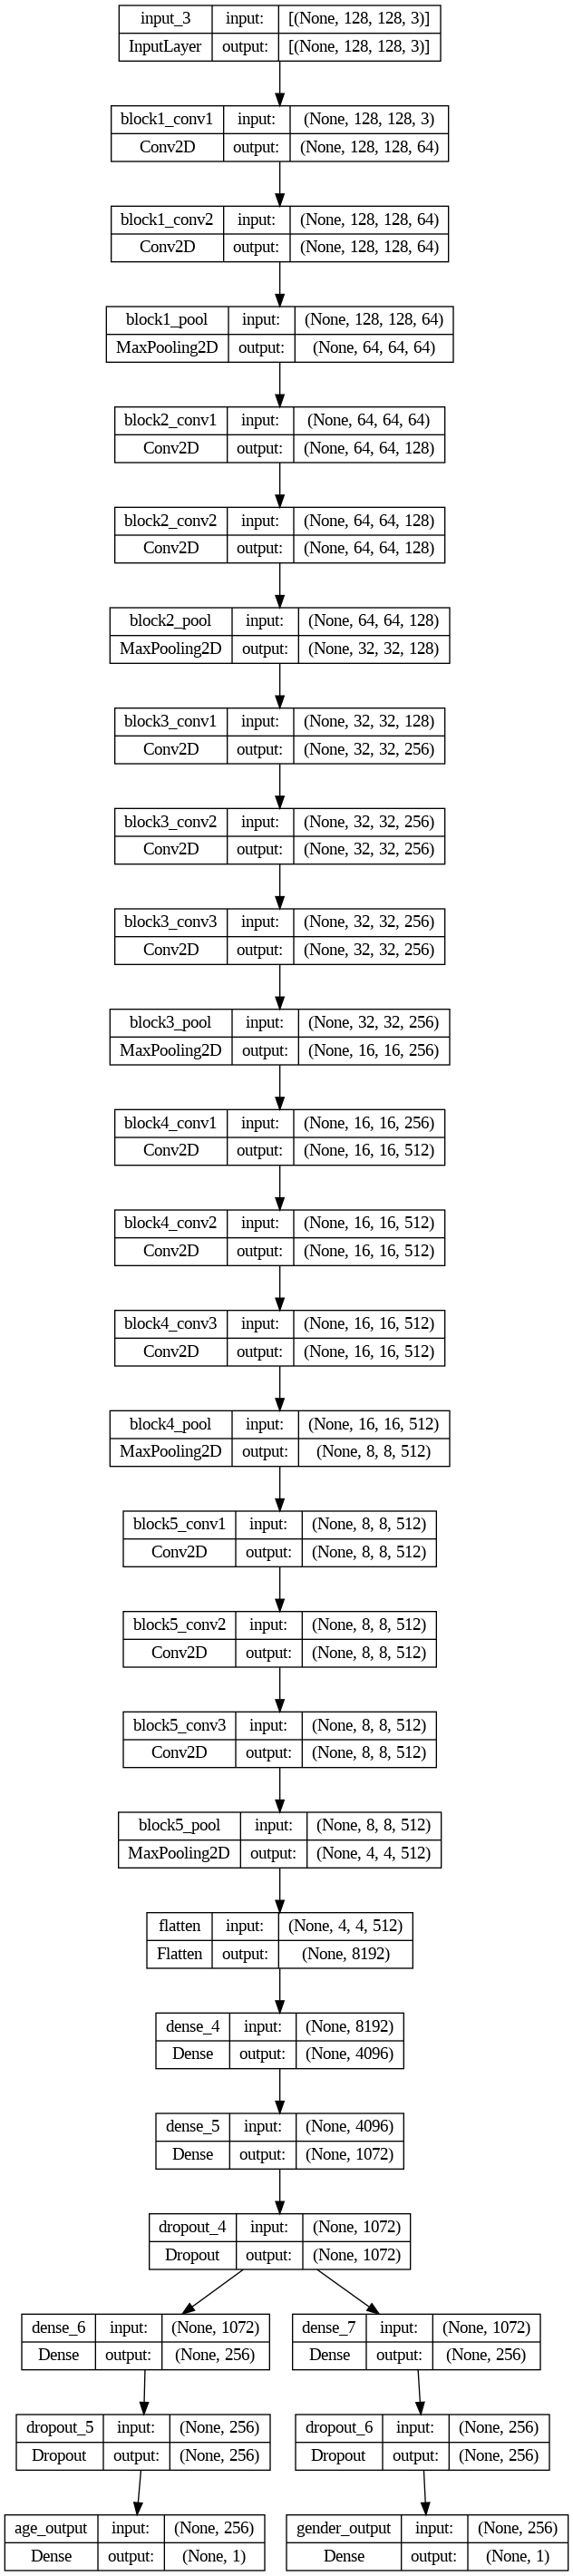

In [ ]:
#
# Add your code here
# STEP 1: Build the CNN network based on a pretrained model
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D

# Load the pre-trained VGG16 model
modelPretrained = VGG16(weights = 'imagenet',
                    include_top = False,
                    input_shape = (128,128,3))
# Freeze the base model
modelPretrained.trainable = False

# # Add custom layers on top of the base model
top_model = modelPretrained.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)

# Age output
age_output = Dense(256, activation='relu')(top_model)
age_output = Dropout(0.5)(age_output)
age_output = Dense(1, activation='linear', name='age_output')(age_output)

# Gender output
gender_output = Dense(256, activation='relu')(top_model)
gender_output = Dropout(0.5)(gender_output)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_output)

# Define the model with two outputs
modelB = Model(inputs=modelPretrained.input, outputs=[age_output, gender_output])
modelB.summary()
from keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
#
# Add your code here
#
#STEP 4: Train the model
modelB.compile(optimizer='adam',
               loss={'age_output': 'mean_absolute_error', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

#STEP 4: Train the model
history_B = modelB.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
model_folder = '/content/drive/MyDrive/Colab Notebooks/models/'
modelB.save(model_folder+"age_gender_B.h5")

Epoch 1/30
250/250 [==============================] - 63s 232ms/step - loss: 1.3048 - age_output_loss: 0.6445 - gender_output_loss: 0.6603 - age_output_mae: 0.6445 - gender_output_accuracy: 0.6610 - val_loss: 0.7545 - val_age_output_loss: 0.3190 - val_gender_output_loss: 0.4355 - val_age_output_mae: 0.3190 - val_gender_output_accuracy: 0.7924
Epoch 2/30
250/250 [==============================] - 56s 223ms/step - loss: 0.8449 - age_output_loss: 0.3326 - gender_output_loss: 0.5123 - age_output_mae: 0.3326 - gender_output_accuracy: 0.7562 - val_loss: 0.6603 - val_age_output_loss: 0.2651 - val_gender_output_loss: 0.3951 - val_age_output_mae: 0.2651 - val_gender_output_accuracy: 0.8257
Epoch 3/30
250/250 [==============================] - 55s 222ms/step - loss: 0.7901 - age_output_loss: 0.3050 - gender_output_loss: 0.4850 - age_output_mae: 0.3050 - gender_output_accuracy: 0.7682 - val_loss: 0.7036 - val_age_output_loss: 0.2625 - val_gender_output_loss: 0.4411 - val_age_output_mae: 0.2625 - 

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

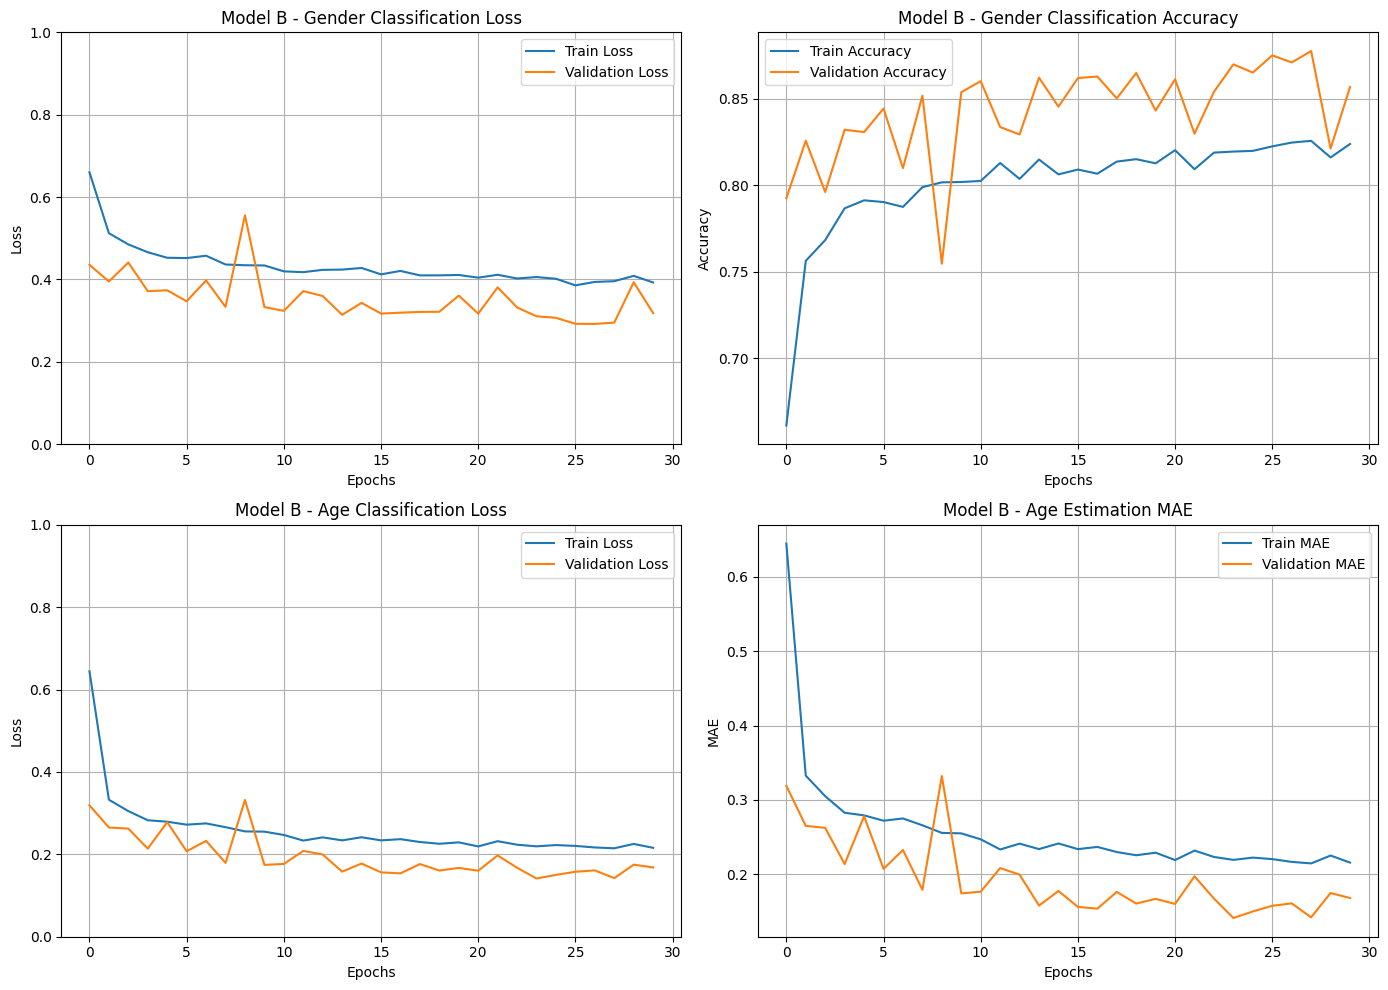

In [ ]:
#
# Add your code here
#
import matplotlib.pyplot as plt

# Create a new figure with a specified size
fig = plt.figure(figsize=(14, 10))

# Gender classification loss
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(history_B.history['gender_output_loss'], label='Train Loss')
ax1.plot(history_B.history['val_gender_output_loss'], label='Validation Loss')
ax1.set_title('Model B - Gender Classification Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax1.set_ylim([0, 1.0])

# Gender classification accuracy
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(history_B.history['gender_output_accuracy'], label='Train Accuracy')
ax2.plot(history_B.history['val_gender_output_accuracy'], label='Validation Accuracy')
ax2.set_title('Model B - Gender Classification Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Age classification loss
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(history_B.history['age_output_loss'], label='Train Loss')
ax3.plot(history_B.history['val_age_output_loss'], label='Validation Loss')
ax3.set_title('Model B - Age Classification Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)
ax3.set_ylim([0, 1.0])

# Age estimation MAE
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(history_B.history['age_output_mae'], label='Train MAE')
ax4.plot(history_B.history['val_age_output_mae'], label='Validation MAE')
ax4.set_title('Model B - Age Estimation MAE')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MAE')
ax4.legend()
ax4.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plots
plt.show()


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#